# Calculating $\Sigma_{10}$


In the context of the paper "[The Sloan Lens ACS Survey. VIII. The Relation between Environment and Internal Structure of Early-Type Galaxies](https://arxiv.org/pdf/0806.1056.pdf)," the projected number density of galaxies inside the tenth nearest neighbor ($\Sigma_{10}$) refers to a measure of the local galaxy density surrounding a target early-type galaxy.

To explain this concept from the paper, we need to understand how the authors calculated $\Sigma_{10}$ and its significance in studying the relationship between galaxy environment and the internal structure of early-type galaxies.

1. Calculation of $\Sigma_{10}$:
In the paper, the authors studied a sample of early-type galaxies with measured gravitational lensing effects. For each target early-type galaxy, they identified its ten nearest neighbor galaxies based on their projected angular distances. The projected angular distance is the angular separation between the target galaxy and its neighbors as seen from our perspective on Earth.

$\Sigma_{10}$ is then calculated as the number of galaxies (including the target galaxy itself) within the combined area covered by the ten nearest neighbors, divided by the total area of that region. In other words, $\Sigma_{10}$ represents the number density of galaxies in the vicinity of the target galaxy, considering the influence of its ten closest neighbors.

2. Significance of $\Sigma_{10}$:
The projected number density $\Sigma_{10}$ is a crucial parameter to study the local galaxy environment around each early-type galaxy in the sample. It provides a measure of the galaxy density on small scales, capturing the immediate gravitational influences of nearby galaxies on the target galaxy.

By analyzing the correlation between $\Sigma_{10}$ and the internal properties of early-type galaxies (such as their effective radii and velocity dispersions), the authors can explore how the local galaxy environment affects the structure and evolution of early-type galaxies. High $\Sigma_{10}$ values imply dense environments with strong gravitational interactions, which might have implications for the growth and assembly history of the early-type galaxies.

In summary, $\Sigma_{10}$ quantifies the local galaxy density surrounding each target early-type galaxy in the sample. It plays a crucial role in understanding the impact of the immediate environment on the internal properties and evolution of these galaxies, providing insights into the complex interplay between galaxy environment and galaxy structure.

Finally calculations can be made by
$$\Sigma_{10} = 10/(\pi R_{10}^2)$$

## Issue for task

https://github.com/ajshajib/BDLensing/issues/191

We've to reproduce **figure no 4** of the SLACS paper for our paper.

## Load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from google.colab import drive
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

!pip install photutils






drive.mount("/content/drive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
Mounted at /content/drive


## Load Data

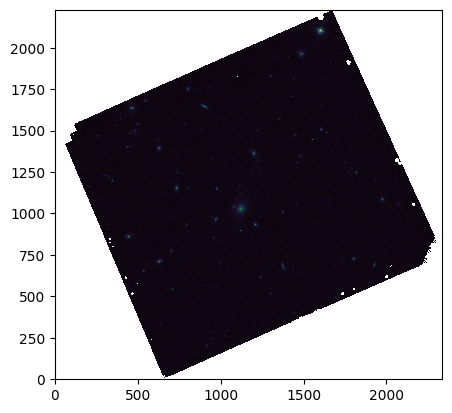

In [2]:
data, header = fits.getdata(
    "/content/drive/MyDrive/BDLensing/DESIJ0132-1600_F140W_drz_sci.fits", header=True
)

plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

<ipython-input-3-1b7fe038732e>:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg.background), origin='lower',


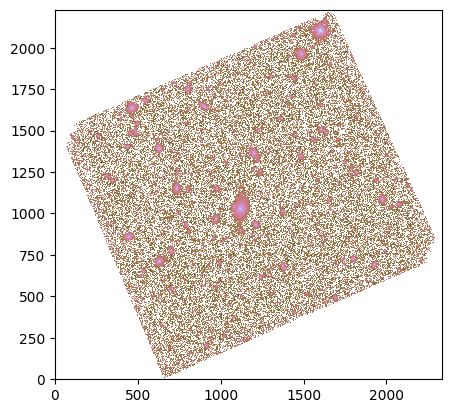

In [3]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [4]:
np.median(bkg.background), np.median(bkg.background_rms)

bkg_subtracted_data = data - bkg.background

threshold = 5 * bkg.background_rms

segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)


finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)

<photutils.segmentation.core.SegmentationImage>
shape: (2230, 2336)
nlabels: 398
labels: [  1   2   3   4   5 ... 394 395 396 397 398]
<photutils.segmentation.catalog.SourceCatalog>
Length: 398
labels: [  1   2   3   4   5 ... 394 395 396 397 398]


<ipython-input-5-a10b92251fd4>:4: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data- bkg.background), origin='lower',


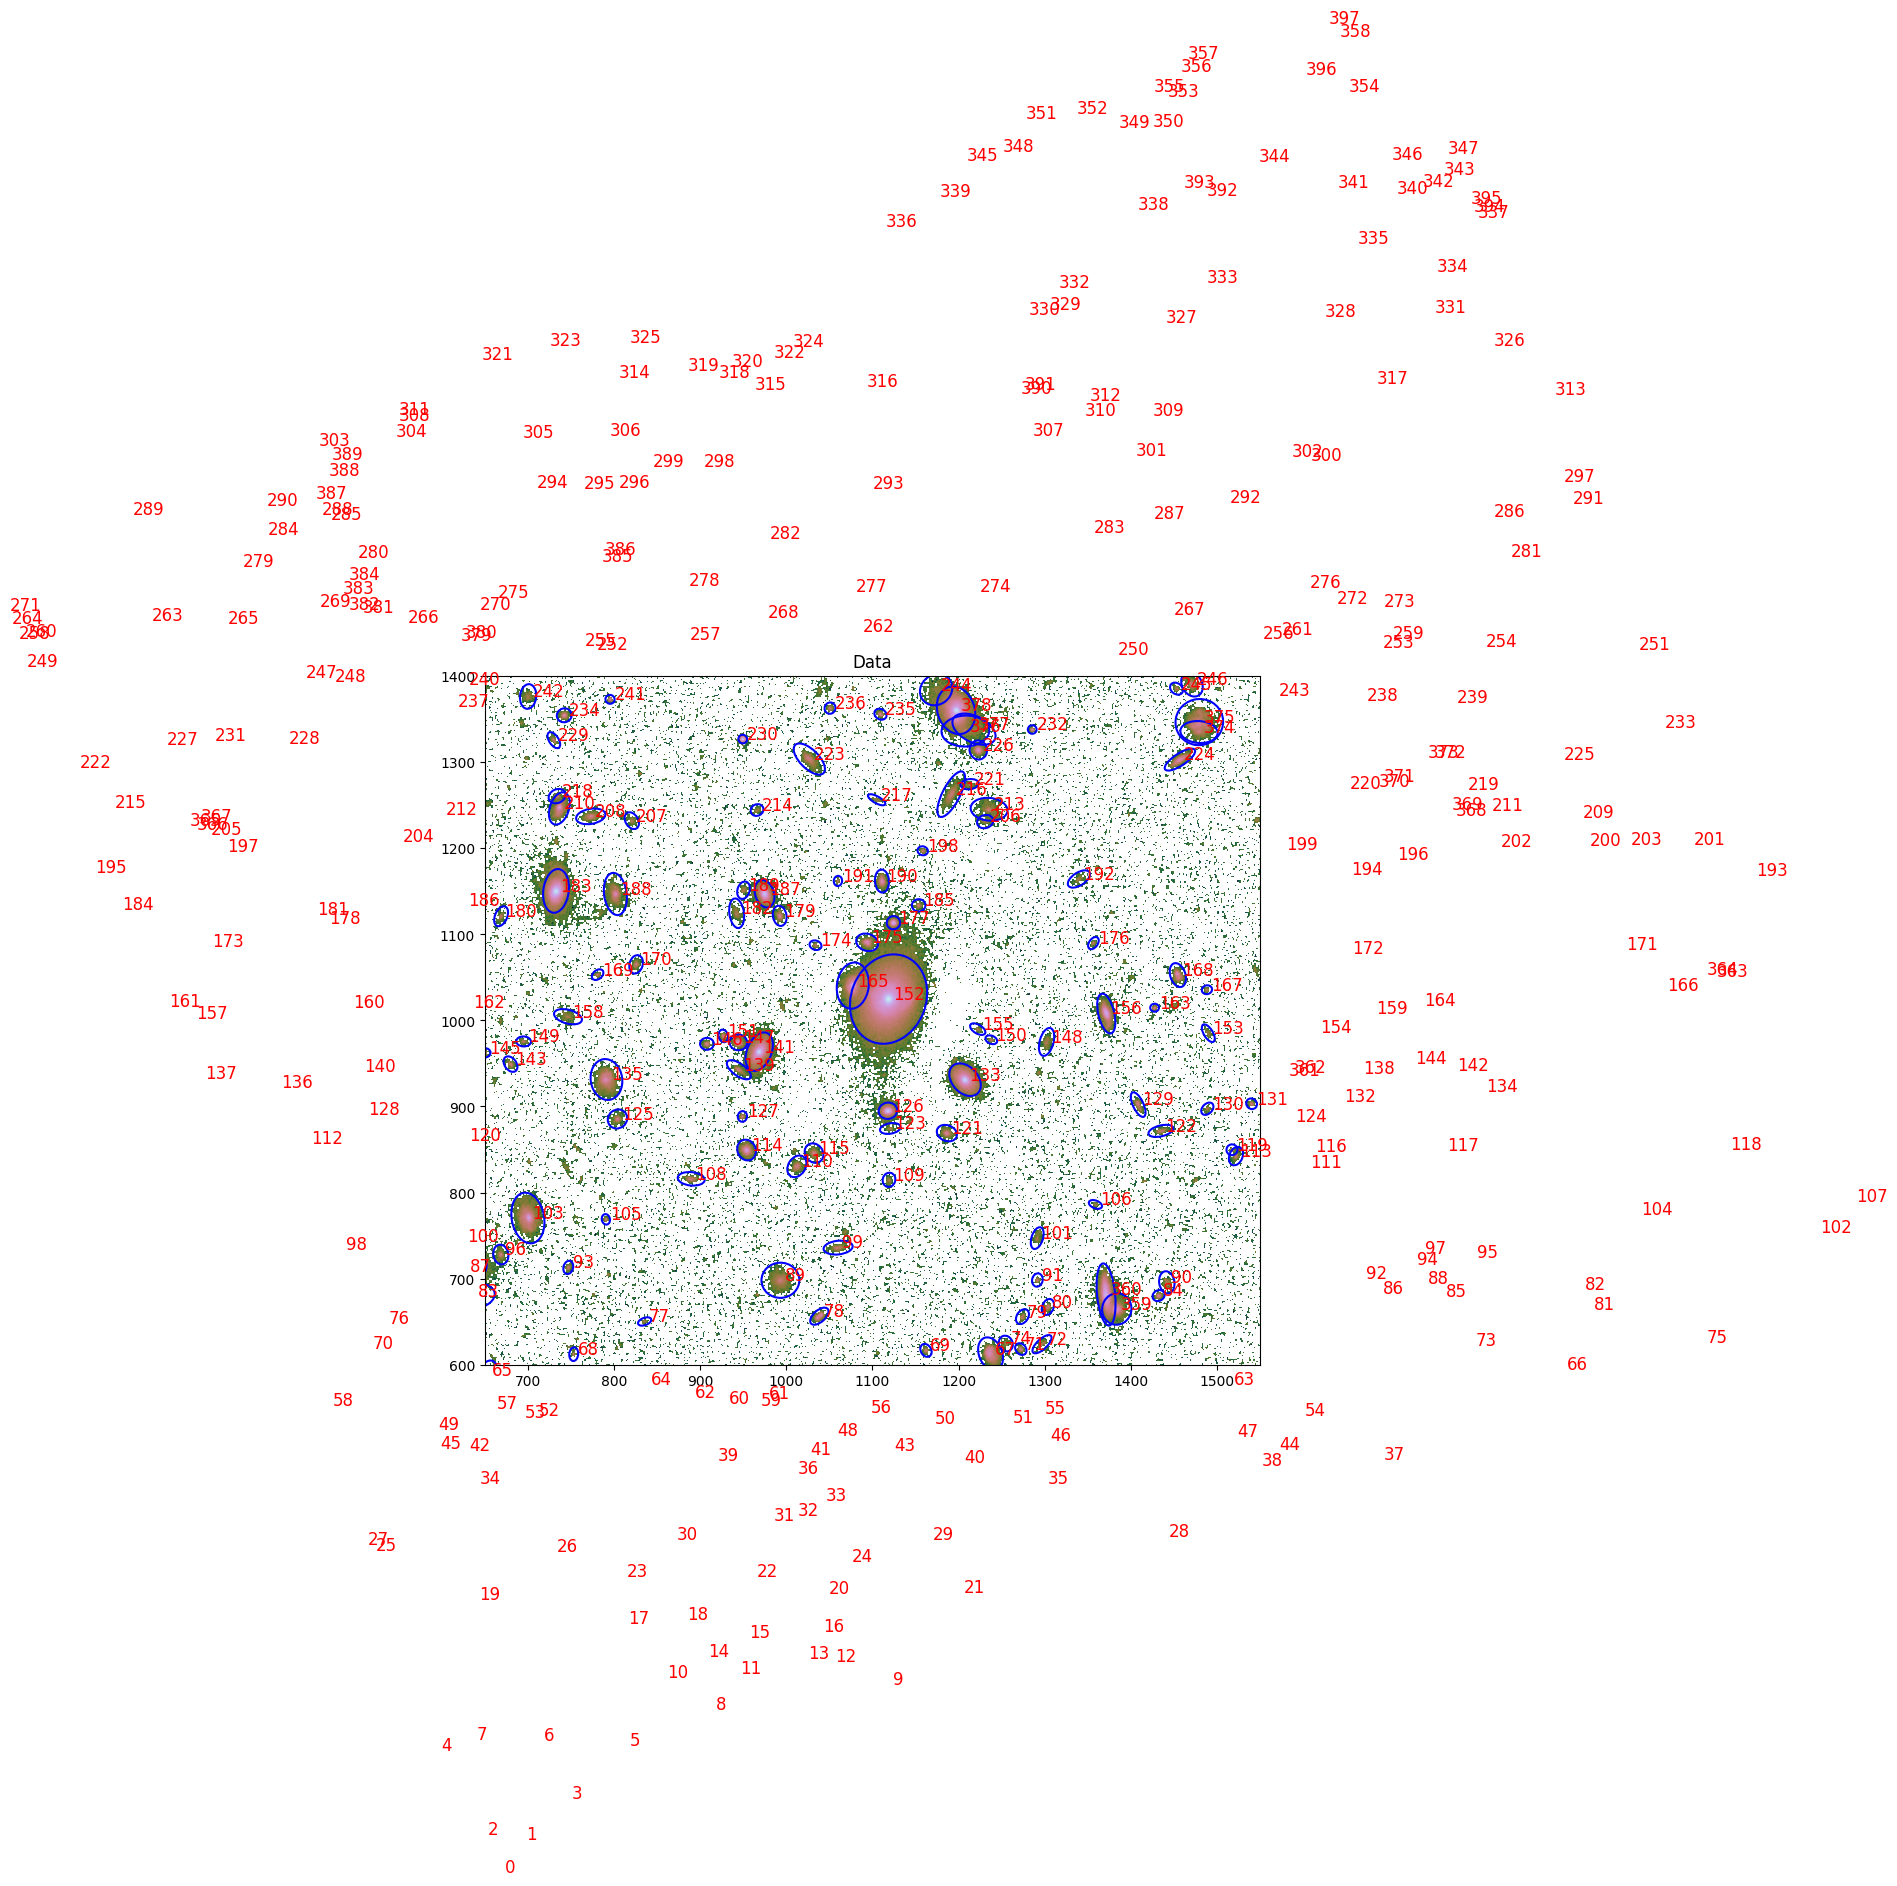

In [5]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(950 - 300, 1250 + 300)
ax1.set_ylim(900 - 300, 1100 + 300)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

<ipython-input-7-bd3dffc04fbc>:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


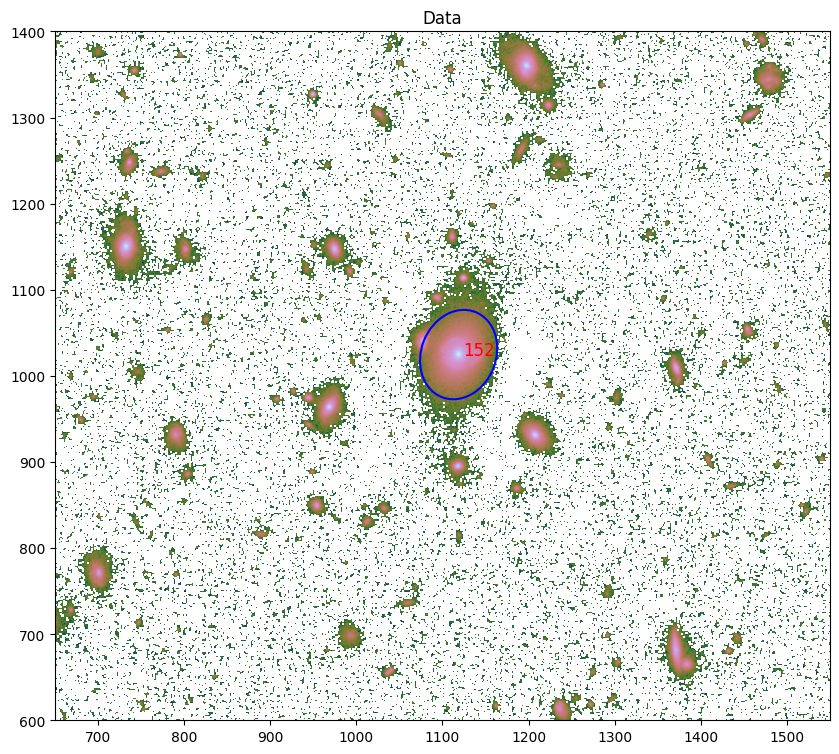

In [7]:
# object id of your central deflector/lens
id_central = 152

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(950 - 300, 1250 + 300)
ax1.set_ylim(900 - 300, 1100 + 300)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Close Galaxies, Distance, Flux

In [8]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

In [25]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.05:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print("Number of All Close galaxies:", len(close_galaxies_all))


print("Close galaxies:", (close_galaxies_all))

Number of All Close galaxies: 70
Close galaxies: [78, 89, 91, 99, 101, 106, 108, 109, 110, 114, 115, 121, 122, 123, 125, 126, 127, 129, 130, 133, 135, 139, 141, 146, 147, 148, 150, 151, 152, 153, 155, 156, 158, 163, 165, 167, 168, 169, 170, 174, 175, 176, 177, 179, 182, 185, 187, 188, 189, 190, 191, 192, 198, 206, 207, 213, 214, 216, 217, 221, 223, 226, 230, 232, 235, 236, 244, 376, 377, 378]


In [26]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.05) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print("Number of Close galaxies excluding dim sources:", len(close_galaxies_1))

print("Close galaxies_1_percent_flux:", (close_galaxies_1))

Number of Close galaxies excluding dim sources: 25
Close galaxies_1_percent_flux: [89, 114, 126, 133, 135, 141, 147, 152, 156, 165, 168, 175, 177, 187, 188, 190, 213, 216, 223, 226, 230, 244, 376, 377, 378]


## Pixel to Arcsec

In [27]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

### Data frame for close galaxies with and without applying 1% flux filter

In [28]:
remove_list = [152]  # list of galaxies you want removed

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 10 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
165         44.363882          3.549111  222.265129    0.683908
175         70.425290          5.634023   35.097931    0.761847
177         88.863546          7.109084   54.177181    0.980457
174        105.404935          8.432395    3.255528    0.762614
155        109.293416          8.743473    3.697351    0.518161
185        114.335265          9.146821    6.876990    0.901948
150        128.326741         10.266139    3.051376    0.655615
133        129.090931         10.327274  402.429428    0.700018
126        129.713761         10.377101  146.333295    0.878969
190        137.267593         10.981407   30.807085    0.608587
191        149.234210         11.938737    2.608702    0.816459
123        150.290316         12.023225    4.954598    0.496026
179        159.121590         12.729727   15.713341    0.666031
141        162.139079         12.971126  401.910618    0.602208
121        169.745868         13.579669 

In [29]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list)

# first 10 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
165         44.363882          3.549111  222.265129    0.683908
175         70.425290          5.634023   35.097931    0.761847
177         88.863546          7.109084   54.177181    0.980457
133        129.090931         10.327274  402.429428    0.700018
126        129.713761         10.377101  146.333295    0.878969
190        137.267593         10.981407   30.807085    0.608587
141        162.139079         12.971126  401.910618    0.602208
147        181.559490         14.524759   36.836687    0.888545
187        188.937501         15.115000  190.747355    0.664048
114        240.670208         19.253617   59.269781    0.854650
216        248.805053         19.904404   31.880595    0.344462
213        249.436923         19.954954   28.508996    0.614012
156        253.411224         20.272898  130.285953    0.392827
223        293.513041         23.481043   30.706219    0.471128
226        307.446272         24.595702 

In [21]:
set_x_lim1, set_x_lim2 = 950 - 300, 1250 + 300
set_y_lim1, set_y_lim2 = 900 - 300, 1100 + 300

### $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation Without filtering 1% flux

<ipython-input-30-f44348d9d214>:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-30-f44348d9d214>:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-30-f44348d9d214>:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-30-f44348d9d214>:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 19.25361662309586
R 20: 27.251189651927934
Sigma 10: 0.008586684134844407
Sigma 20: 0.008572533493818969

FOR All SOURCES
R 10: 10.98140741234701
R 20: 15.37870842875462
Sigma 10: 0.02639575683086577
Sigma 20: 0.026917851747399097


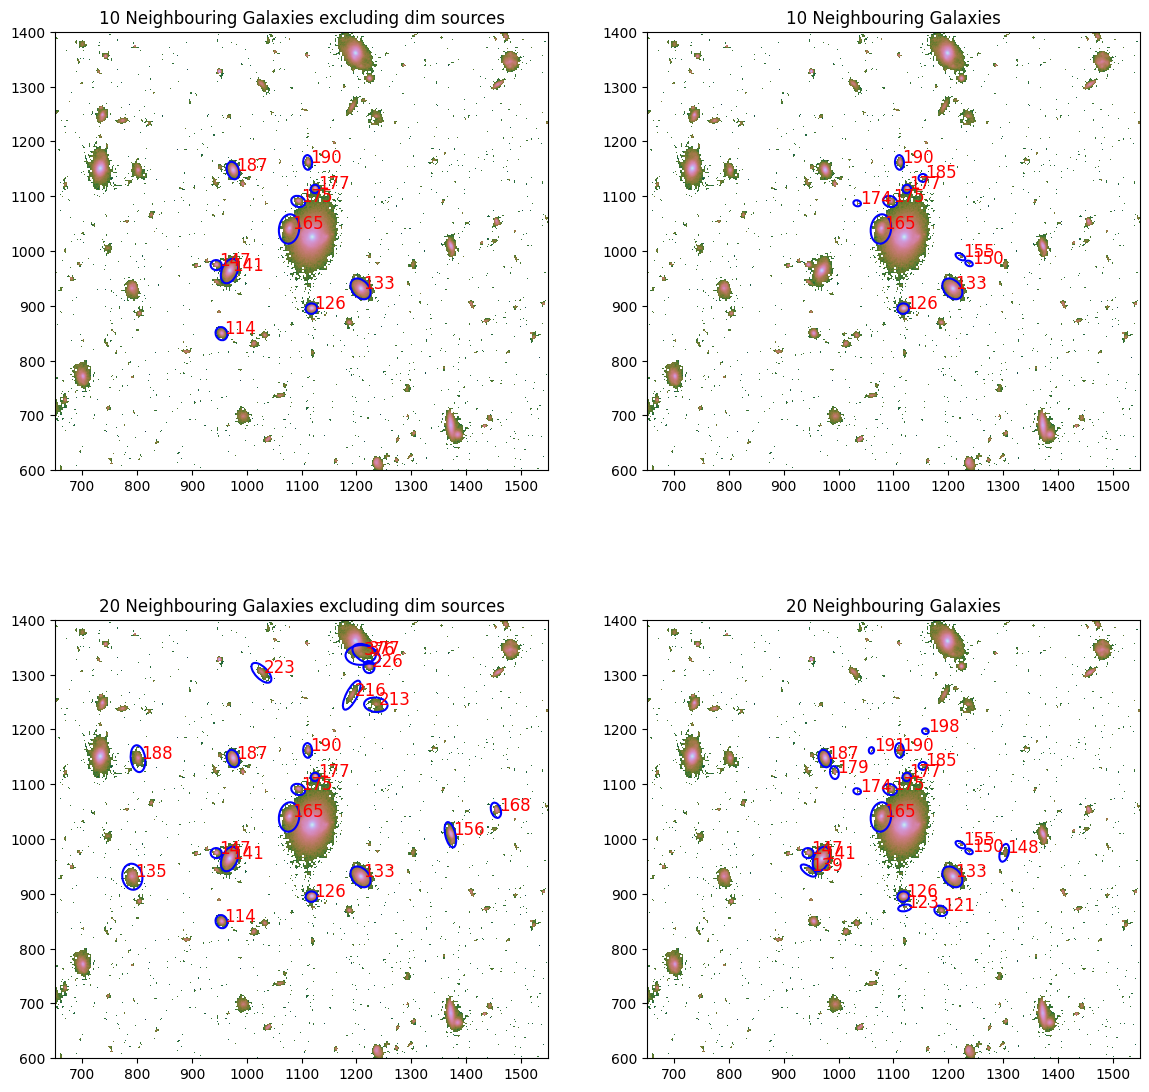

In [30]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)